In [1]:
import os
import tqdm
import xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
%matplotlib inline


def notify(title, subtitle='', message=''):
    t = '-title {!r}'.format(title)
    s = '-subtitle {!r}'.format(subtitle)
    m = '-message {!r}'.format(message)
    os.system('terminal-notifier {}'.format(' '.join([m, t, s])))

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
def is_vowel(ch):
    return ch.lower() in 'уеыаоэёяию'

def is_consonant(ch):
    return ch.lower() in 'йцкнгшщзхъфвпрлджчсмтьб'

def num_vowels(string):
    string = clean_string(string)
    ans = 0
    for c in string:
        if is_vowel(c):
            ans += 1
    return ans

def is_caps(string):
    """
    RETURNS
    -------
    int : {0,1,2}
        0 - all chars are caps
        1 - only first char is caps
        2 - all chars are lower
    
    """
    if all(list(map(lambda x: x.isupper(), string))):
        return 0
    elif string[0].isupper():
        return 1
    else:
        return 2

    
def repl_vowels(string):
    string = string.lower()
    to_repl_o = list('ôó')
    to_repl_e = list('éѐёë')
    for sym in to_repl_o:
        string = string.replace(sym, 'о')
    for sym in to_repl_e:
        string = string.replace(sym, 'е')
    string = string.replace('á', 'а')
    return string.strip()


def repl_symbs(string):
    string = string.lower()
    to_repls = list('1234567890“\"·»\'.\xa0&«/`\\-’” ')
    for sym in to_repls:
        string = string.replace(sym, '')
    return string.strip()


def clean_string(string):
    tmp = repl_symbs(repl_vowels(string))
    if len(tmp) == 1:
        tmp = tmp + tmp
    return tmp


def get_vector(ch_gram, gram_alphabet):
    ch_gram = ch_gram.lower()
    tmp = np.zeros(len(gram_alphabet))
    if ch_gram in gram_alphabet:
        tmp[gram_alphabet.index(ch_gram)] = 1
    return tmp


def string_to_vec(string, gram_alphabet):
    string = clean_string(string.lower())
    string = string[-4:]
    if len(string) == 1:
        string = string + string
    grams = make_ngrams(string, 2)
    tmp_ans = np.zeros(len(gram_alphabet))
    for gram in grams:
        tmp_ans += get_vector(gram, gram_alphabet)
    return tmp_ans / len(grams)


def make_ngrams(string, n=2):
    string = string.lower()
    return [string[i:i+n] for i in range(len(string) - n + 1)]


def index_of_last_pair(string, gram_alphabet):
    string = clean_string(string.lower())
    string = clean_string(string)
    if len(string) == 1:
        string = string + string
    return gram_alphabet.index(string[-2:].lower())


def index_of_first_pair(string, gram_alphabet):
    string = clean_string(string.lower())
    string = clean_string(string)
    if len(string) == 1:
        string = string + string
    return gram_alphabet.index(string[:2])
    return gram_alphabet.index(string[:2].lower())


# alphabet = 'абвгдежзийклмнопрстуфхцчшщъыьэюяАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ'
alphabet = ''.join([chr(i) for i in range(ord('а'), ord('я')+1)])
ch_gram_alphabet = []

for i in alphabet:
    for j in alphabet:
        ch_gram_alphabet.append(i + j)

print(len(ch_gram_alphabet))

print(ch_gram_alphabet.index('ля'))

1024
383


In [9]:
%%time
test = pd.read_csv("linear_test.txt", header=None, names=['x'])
train = pd.read_csv("linear_train.txt", header=None, names=['x', 'y'])

# train['x'] = list(map(lambda x: clean_string(x), train['x']))
# test['x'] = list(map(lambda x: clean_string(x), test['x']))

train_y = train['y']
train = train.drop(['y'], axis=1)

ch_gram_alphabet = list(set.union(set(list(map(lambda x: clean_string(x)[-2:].lower(), train['x']))), 
                                  set(list(map(lambda x: clean_string(x)[-2:].lower(), test['x']))), 
                                  set(list(map(lambda x: clean_string(x)[:2].lower(), train['x']))), 
                                  set(list(map(lambda x: clean_string(x)[:2].lower(), test['x']))), 
                                  set(ch_gram_alphabet)))

# ch_gram_alphabet = list(set.union(set(list(map(lambda x: clean_string(x)[-2:], train['x']))), 
#                                   set(list(map(lambda x: clean_string(x)[-2:], test['x']))), 
#                                   set(list(map(lambda x: clean_string(x)[:2], train['x']))), 
#                                   set(list(map(lambda x: clean_string(x)[:2], test['x']))), 
#                                   set(ch_gram_alphabet)))

print(len(ch_gram_alphabet))

train['length'] = list(map(lambda x: len(x), train['x']))
train['vowels'] = list(map(lambda x: num_vowels(x), train['x']))
train['caps'] = list(map(lambda x: is_caps(x), train['x']))
# train['last'] = list(map(lambda x: ord(x[-1].lower()), train['x']))
# train['first'] = list(map(lambda x: ord(x[0].lower()), train['x']))
train['last_pair'] = list(map(lambda x: index_of_last_pair(x, ch_gram_alphabet), train['x']))
train['first_pair'] = list(map(lambda x: index_of_first_pair(x, ch_gram_alphabet), train['x']))

test['length'] = list(map(lambda x: len(x), test['x']))
test['vowels'] = list(map(lambda x: num_vowels(x), test['x']))
test['caps'] = list(map(lambda x: is_caps(x), test['x']))
# test['last'] = list(map(lambda x: ord(x[-1].lower()), test['x']))
# test['first'] = list(map(lambda x: ord(x[0].lower()), test['x']))
test['last_pair'] = list(map(lambda x: index_of_last_pair(x, ch_gram_alphabet), test['x']))
test['first_pair'] = list(map(lambda x: index_of_first_pair(x, ch_gram_alphabet), test['x']))

sample_submission = pd.read_csv("linear_ans_example.txt")

print(sum(train_y)/len(train_y))

1024
0.10491282739
CPU times: user 37 s, sys: 402 ms, total: 37.4 s
Wall time: 38.9 s


# First Stupid Predictions

In [10]:
# %%time
# clf = XGBClassifier()

# train_x = train.drop(['x'], axis=1)
# clf.fit(train_x, train_y)

# print(accuracy_score(train_y, clf.predict(train_x)))

# preds = clf.predict(train_x)
# preds_prob = clf.predict_proba(train_x)

# plt.hist(preds_prob[:, 1])
# plt.show()
# print(any(preds))

# plt.plot(preds)
# plt.show()

# stupid_preds = clf.predict_proba(train_x)[:,1]

# print(roc_auc_score(train_y, stupid_preds))

# Some Research...

In [11]:
all_symbs = set.union(set((''.join(test['x'])).lower()), set((''.join(train['x'])).lower()))
print('All symbols:', all_symbs)
print(len(all_symbs))

All symbols: {'«', '&', 'ш', 'м', '.', 'у', 'ф', '-', 'ѐ', 'á', 'в', '1', '“', '`', 'е', 'ъ', 'а', '·', '"', '/', 'и', 'л', 'с', '»', 'ц', 'н', 'г', ' ', '7', 'щ', 'ё', 'é', 'ы', '2', 'й', 'ч', 'ж', 'б', 'р', '’', 'ë', 'к', '”', 'ю', 'я', 'п', '\xa0', 'з', 'д', '4', 'х', 'ô', '3', 'ь', '\\', "'", 'о', '0', 'э', 'ó', 'т'}
61


In [12]:
print(set.difference(all_symbs, list('йцукенгшщзхъфывапролджэячсмитьбю' + 'á' + '1234567890“\"·»\'.\xa0&«/`' + 'ôó' + 'éѐёë')))

{'-', ' ', '’', '”', '\\'}


In [13]:
mat = np.random.uniform(0, 1, len(ch_gram_alphabet))
print(np.dot(mat, string_to_vec('квартира', ch_gram_alphabet)))
string_to_vec('аа', ch_gram_alphabet)

0.653055958571


array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

# Encode every string with vectors

In [14]:
train.head()

,x,length,vowels,caps,last_pair,first_pair
0,Аалтонен,8,4,1,899,55
1,Аар,3,2,1,885,55
2,Аарон,5,3,1,32,55
3,ААРОН,5,3,0,32,55
4,Аарона,6,4,1,271,55


In [15]:
%%time
new_train = pd.DataFrame(columns=np.concatenate((train.columns.values, np.arange(len(ch_gram_alphabet)))))
new_train

res = []

for i in tqdm.tqdm(range(len(train))):
    res.append(np.concatenate((train.iloc[i], string_to_vec(train.iloc[i]['x'], gram_alphabet=ch_gram_alphabet))))
    
new_train = pd.DataFrame(data=res, columns=np.concatenate((train.columns.values, np.arange(len(ch_gram_alphabet)))))
    
notify('kek_1')

100%|██████████| 101408/101408 [01:05<00:00, 1556.90it/s]


CPU times: user 1min 37s, sys: 21.6 s, total: 1min 58s
Wall time: 2min 11s


In [16]:
tmp = []
for col in new_train.columns.values[1:]:
    tmp.append(np.isnan(new_train[col]))
    
notify('Checked!')

ans = []
for x in tmp:
    ans.append(any(x))
    
any(ans)

False

In [17]:
list(tmp[5]).count(True)

0

In [18]:
min(list(map(lambda x: len(x), train['x'])))

1

In [153]:
# train_y = train_y.iloc[[en for en, x in enumerate(list(map(lambda x: len(x), train['x']))) if x > 1]]
# train = train.iloc[[en for en, x in enumerate(list(map(lambda x: len(x), train['x']))) if x > 1]]

In [19]:
logreg = LogisticRegression()

In [20]:
%%time
logreg.fit(new_train.drop(['x'], axis=1), train_y)
notify('Trained!')

CPU times: user 3.85 s, sys: 2.15 s, total: 6 s
Wall time: 7.46 s


(array([ 98670.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   2738.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

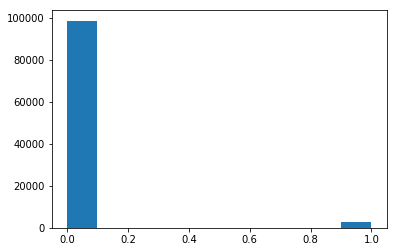

In [21]:
log_preds = logreg.predict(new_train.drop(['x'], axis=1))
plt.hist(log_preds)

In [22]:
# accuracy_score(train_y, log_preds)
roc_auc_score(train_y, logreg.predict_proba(new_train.drop(['x'], axis=1))[:,1])

0.85294109658268669

In [23]:
sum(log_preds)

2738

In [24]:
new_train.head()

,x,length,vowels,caps,last_pair,first_pair,0,1,2,3,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,Аалтонен,8,4,1,899,55,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Аар,3,2,1,885,55,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Аарон,5,3,1,32,55,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ААРОН,5,3,0,32,55,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Аарона,6,4,1,271,55,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
%%time
clf = XGBClassifier(max_depth=20)
clf.fit(new_train.drop(['x'], axis=1), train_y)
notify('Trained!')

CPU times: user 28min 35s, sys: 14.4 s, total: 28min 50s
Wall time: 8min 53s


In [26]:
%%time
preds = clf.predict(new_train.drop(['x'], axis=1))

print(sum(train_y)/len(train_y))
print(sum(preds)/len(preds))

# it was 0.90675291890186183 with 0.87 on public leaderboard
# it was 0.95879023351214898 with 0.92 on public leaderboard
# it was 0.968493609972 with 0.92 on public leaderboard with 'length'
# it was 0.965722625434 with 0.92 on public leaderboard without 'length'
print(accuracy_score(train_y, preds))
# 0.938603843916
# 0.960742355064

0.10491282739
0.0603601293784
0.945980593247
CPU times: user 7.62 s, sys: 4.53 s, total: 12.2 s
Wall time: 10.5 s


In [27]:
roc_auc_score(train_y, clf.predict_proba(new_train.drop(['x'], axis=1))[:, 1])
# 0.958280574696595
# 0.98766937781938924
# got bad results only with pair_indexes and num of vowels

0.97173131265907708

In [52]:
short_indices = [en for en, x in enumerate(list(map(lambda x: len(x), test['x']))) if x == 1]

In [28]:
%%time

new_test = pd.DataFrame(columns=np.concatenate((test.columns.values, np.arange(len(ch_gram_alphabet)))))
new_test

res_test = []

for i in tqdm.tqdm(range(len(test))):
    res_test.append(np.concatenate((test.iloc[i], string_to_vec(test.iloc[i]['x'], ch_gram_alphabet))))
    
new_test = pd.DataFrame(data=res_test, columns=np.concatenate((test.columns.values, np.arange(len(ch_gram_alphabet)))))

notify('kek_2')

100%|██████████| 188920/188920 [01:56<00:00, 1615.50it/s]


CPU times: user 3min 4s, sys: 59.5 s, total: 4min 3s
Wall time: 4min 53s


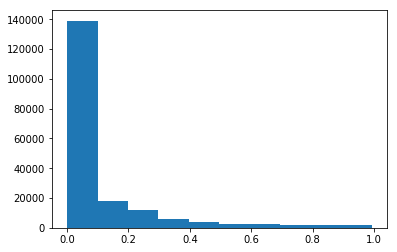

CPU times: user 13.8 s, sys: 10.6 s, total: 24.5 s
Wall time: 25.5 s


In [29]:
%%time
sample_submission['Answer'] = clf.predict_proba(new_test.drop(['x'], axis=1))[:, 1]

plt.hist(sample_submission['Answer'])
plt.show()

In [30]:
[(test.iloc[i]['x'], sample_submission.iloc[i]['Answer']) for i in [i for i, x in enumerate(sample_submission['Answer']) if x > 0.5]]

[('Ааронов', 0.57114416),
 ('Абаева', 0.92472637),
 ('Абаевым', 0.92837924),
 ('Абакумова', 0.9623242),
 ('АБАКУМОВА', 0.93468249),
 ('Абакумову', 0.95930171),
 ('Абакумовым', 0.97391719),
 ('Абалкин', 0.87021726),
 ('Абаринов', 0.56230944),
 ('Абасов', 0.52523643),
 ('Аббасова', 0.9508996),
 ('Аббасову', 0.96897709),
 ('Аббот', 0.59167886),
 ('Абдрахманова', 0.94989854),
 ('Абдулина', 0.5725773),
 ('Абдуллаев', 0.83250874),
 ('Абдуллаева', 0.90922755),
 ('Абдуллаеву', 0.88613981),
 ('Абдуллаевым', 0.97382069),
 ('Абелева', 0.92100364),
 ('Абелевым', 0.93774128),
 ('Абердину', 0.51017237),
 ('Абиевым', 0.92837924),
 ('Абилов', 0.60503584),
 ('Аблязов', 0.53369641),
 ('Абнер', 0.58272171),
 ('Абрамкин', 0.82618773),
 ('Абрамкина', 0.89941394),
 ('Абрамов', 0.51891053),
 ('Абрамова', 0.94284344),
 ('Абрамовичем', 0.76504332),
 ('Абрамовичу', 0.63293731),
 ('Абрамовой', 0.92264116),
 ('Абрамову', 0.95894408),
 ('Абрамовым', 0.96396804),
 ('Абрамс', 0.65703791),
 ('Абрамса', 0.84590006),
 

In [44]:
sample_submission.to_csv("submission.csv", sep=',', index=False)
notify('Done with submission!')

In [32]:
%%time
lrs = LogisticRegression()

lrs.fit(new_train.drop(['x','vowels', 'caps', 'length', 'first_pair', 'last_pair'], axis=1), train_y)
notify('LR Trained!')

CPU times: user 2.68 s, sys: 2.58 s, total: 5.26 s
Wall time: 7.55 s


In [39]:
roc_auc_score(train_y, lrs.predict_proba(new_train.drop(['x','vowels', 'caps', 'length', 'first_pair', 'last_pair'], axis=1)))

ValueError: bad input shape (101408, 2)

In [42]:
sample_submission['Answer'] = lrs.predict_proba(new_test.drop(['x','vowels', 'caps', 'length', 'first_pair', 'last_pair'], axis=1))[:, 1]

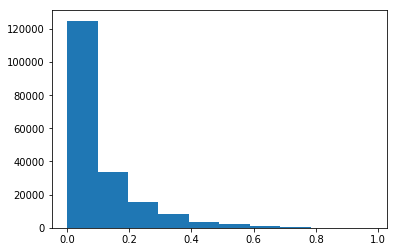

In [43]:
plt.hist(sample_submission['Answer'])
plt.show()